# Reproducible results  for $\LaTeX{}$ manuscripts

* arbitrary narrative text and results
* pandas $\LaTeX$ table generation
* custom APA-style table generation
* APA-style graphics styled with matplotlib style sheets


**WARNING**: Running this code the first time downloads an 87MB EEG data file to your disk from Zenodo.


The package dependencies are python, numpy, pandas, pyarrow, matplotlib, jupyter

# The reproducible data analysis


Set up Python packages for data analysis and visualization

Guard the conda environment and EEG file MD5 checksum

In [1]:
import os
import re
import copy
import hashlib
import warnings
from pathlib import Path
import pprint as pp
import platform
import numpy as np
import pandas as pd


# matplotlib and packages for plot tuning
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cycler
from matplotlib import cm

# guard conda environment
conda_env = os.environ["CONDA_DEFAULT_ENV"] if "CONDA_DEFAULT_ENV" in os.environ.keys() else None

if conda_env and not conda_env == "apa67_report_090421":
    msg = (
        f"unknown conda env {conda_env}, to reproduce the report on linux create run these:\n\n"
        f"    conda create -n apa67_report_090421 --files environment.txt\n"
        f"    conda activate \n\n"
    )
    warnings.warn(msg)

# fetch the EEG recording from Zenodo if it isn't found locally
ARCHIVE = r"https://zenodo.org/record/4099632/files/"

DATA_F = "sub000p3.ms1500.epochs.feather"
if not Path(DATA_F).exists():
    print(f"downloading {DATA_F} from Zenodo ... please wait")
    pd.read_feather(ARCHIVE + DATA_F).to_feather(DATA_F)
    print("ok")

# guard the data file MD5 ... note the pd.read_feather file md5 is NOT == to zenodo md5.
with open(DATA_F, 'rb') as _f:
    checksum = hashlib.md5(_f.read()).hexdigest()
    if not checksum == "faedff42de40ff1972baecf61f804aea":
        raise ValueError(f"bad md5 checksum {DATA_F}")

print(f"{DATA_F} ok")

for pkg in [np, pd, mpl]:
    print(pkg.__name__, pkg.__version__)
    

downloading sub000p3.ms1500.epochs.feather from Zenodo ... please wait
ok
sub000p3.ms1500.epochs.feather ok
numpy 1.21.2
pandas 1.3.2
matplotlib 3.4.3


# Experiment parameters

## Electrode and fiducial landmark locations

In [2]:
# ------------------------------------------------------------
# scalp electrodes, EOG, mastoids, ground
import io
sph26_txt = io.StringIO("""
channel  phi   theta  ch_type
MiPf  90.0   90.0   eeg
LLPf  90.0  126.0   eeg
LLFr  90.0  162.0   eeg
LLTe  90.0  198.0   eeg
LLOc  90.0  234.0   eeg
MiOc  90.0  270.0   eeg
RLOc  90.0  306.0   eeg
RLTe  90.0  342.0   eeg
RLFr  90.0   18.0   eeg
RLPf  90.0   54.0   eeg
LMPf  59.0  108.0   eeg
LDFr  59.0  144.0   eeg
LDCe  59.0  180.0   eeg
LDPa  59.0  216.0   eeg
LMOc  59.0  252.0   eeg
RMOc  59.0  288.0   eeg
RDPa  59.0  324.0   eeg
RDCe  59.0    0.0   eeg
RDFr  59.0   36.0   eeg
RMPf  59.0   72.0   eeg
LMFr  26.0  126.0   eeg
LMCe  26.0  198.0   eeg
MiPa  26.0  270.0   eeg
RMCe  26.0  342.0   eeg
RMFr  26.0   54.0   eeg
MiCe   0.0    0.0   eeg
A1    130.0  205.0  ref
A2    130.0  335.0  ref
lle   140.0  120.0  eog
rle   140.0   60.0  eog
lhz   108.0  130.0  eog
rhz   108.0   50.0  eog
nasion 108.0  90.0  fid
lpa    108.0 180.0  fid
rpa    108.0   0.0  fid
gnd     72.0   90.0 gnd
""")

# parse lcoations into a data frame
SPH_LOCS = pd.read_csv(sph26_txt, sep="\s+")
SPH_LOCS.insert(3, "r", np.sin(SPH_LOCS["phi"]))
SPH_LOCS

def sph2cart(row):
    """convert spherical coordinates to 2-D cartesian"""
    row = row.copy()
    label, phi, theta, r, ch_type = [*row]

    deg2rad = 2.0 * np.pi / 360.0
    phi *= deg2rad
    theta *= deg2rad

    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)

    # lambert projection
    lambert_x = x * np.sqrt(1 / (1 + z))
    lambert_y = y * np.sqrt(1 / (1 + z))

    row['x'], row['y'], row['z'] = x, y, z
    row['x_lambert'], row['y_lambert'] = lambert_x, lambert_y

    return row

SPH_CART_LOCS = SPH_LOCS.apply(lambda row: sph2cart(row), axis=1)


## Data columns and indexes

In [3]:
INDEXES = ["epoch_id", "time_ms"]
EEG_MIDLINE = ["MiPf", "MiCe", "MiPa", "MiOc"]
EXPT_VARS =  ["bin", "tone", "stimulus", "accuracy"]

EEG_COLUMNS = SPH_LOCS.query("ch_type == 'eeg'")["channel"].tolist()
COI = INDEXES + EXPT_VARS + EEG_COLUMNS # EEG_MIDLINE

## Groom the recordings for analysis

In [4]:
data = pd.read_feather("sub000p3.ms1500.epochs.feather")
data.rename(columns={"match_time": "time_ms"}, inplace=True)
data["epoch_id"] = data["epoch_id"].astype(int)
data.rename(columns={"stim": "stimulus"}, inplace=True)

# data QC screening
display(len(data.epoch_id.unique()))
good_epoch_ids = data.query("time_ms==0 and log_flags==0").epoch_id
data = data.query("epoch_id in @good_epoch_ids")
print(data.columns)

good_epochs = []
absmax = 125
for epoch_id, epoch in data.groupby("epoch_id"):
    vals = epoch[EEG_COLUMNS].to_numpy().flatten()
    if vals.max() - vals.min() <= absmax:
        
        # center EEG on mean amplitude 200 - 0 ms prestimulus
        epoch[EEG_COLUMNS] = (
            epoch[EEG_COLUMNS] 
            - epoch.query("time_ms >= -200 and time_ms < 0")[EEG_COLUMNS].mean()
        )
        good_epochs.append(epoch)

p3_eeg = pd.concat(good_epochs, axis=0)


# save 
p3_eeg[COI].reset_index(drop=True).to_feather("p3_eeg.fthr")

600

Index(['epoch_id', 'data_group', 'dblock_path', 'dblock_tick_idx',
       'dblock_ticks', 'crw_ticks', 'raw_evcodes', 'log_evcodes', 'log_ccodes',
       'log_flags', 'epoch_match_tick_delta', 'epoch_ticks', 'dblock_srate',
       'match_group', 'idx', 'dlim', 'anchor_str', 'match_str', 'anchor_code',
       'match_code', 'anchor_tick', 'match_tick', 'anchor_tick_delta',
       'is_anchor', 'regexp', 'ccode', 'instrument', 'bin', 'tone', 'stimulus',
       'accuracy', 'acc_type', 'time_ms', 'anchor_time', 'anchor_time_delta',
       'diti_t_0', 'diti_hop', 'diti_len', 'pygarv', 'lle', 'lhz', 'MiPf',
       'LLPf', 'RLPf', 'LMPf', 'RMPf', 'LDFr', 'RDFr', 'LLFr', 'RLFr', 'LMFr',
       'RMFr', 'LMCe', 'RMCe', 'MiCe', 'MiPa', 'LDCe', 'RDCe', 'LDPa', 'RDPa',
       'LMOc', 'RMOc', 'LLTe', 'RLTe', 'LLOc', 'RLOc', 'MiOc', 'A2', 'HEOG',
       'rle', 'rhz'],
      dtype='object')


## Load the groomed EEG data

In [5]:
p3_df = pd.read_feather("p3_eeg.fthr")
p3_events = p3_df.query("time_ms == 0 and stimulus != 'cal'")[INDEXES + EXPT_VARS]

display(len(p3_df.epoch_id.unique()))
display(p3_events.shape)

447

(239, 6)

## Tabulate stimulus event counts by experimental condition

In [6]:
event_table = pd.crosstab(p3_events.stimulus, p3_events.tone, margins=True)

# event_table.columns = [col for col in event_table.columns]
event_table.reset_index(inplace=True)

# event_table["stimulus"] = event_table["stimulus"].str.capitalize()
# event_table.columns = event_table.columns.str.capitalize()

event_table.set_index("stimulus", inplace=True)
display(event_table)

tone,hi,lo,All
stimulus,,,
standard,107,94,201
target,14,24,38
All,121,118,239


# Example: Linking data and arbitrary text

In [7]:
# data variables from the table for clarity
n_trials = event_table["All"]["All"]
n_standards = event_table.loc["standard"]["All"]
n_targets = event_table.loc["target"]["All"]

# a bit of data validation
assert n_standards + n_targets == event_table["All"]["All"]

# compute the proportion ... a derived value
p_targets = n_targets / (n_standards + n_targets)
n_trials, n_standards, n_targets, p_targets

(239, 201, 38, 0.1589958158995816)

In [8]:
# embed data into formatted LaTex via the variables

arbitrary_text = f"""
% These two paragraphs are generated when the analysis is run

The essential feature of reproducible report generation is linking
data from the analysis with the text of the report. Style conventions
like APA 6\\textsuperscript{{th}}, 7\\textsuperscript{{th}} and others are 
strict and varied which means the only general solution is a mechanism
for linking the analysis data and results to arbitrary text formatted 
arbitrarily.  This is an old problem, solved long ago by string formatting
functions, e.g., \mintinline{{c}}{{sprintf()}} in C, which reappears in 
various forms in scripting languages like R, MATLAB, and Python where the
f-string function (Python 3.6+) streamlines mixing text and variables.

To illustrate, the same Jupyter notebook that runs the analysis also
generates a text file containing the entire contents of the preceding 
paragraph and this one, including the following sentence that describes 
the number of trials in each experimental condition. 
%%
%% In the next sentence, the Python f-string formatter embeds variables 
%% computed during the analysis directly into the generated text which
%% typeset to APA 6th style specifications.
%% 
After screening  artifacts, the proportion of target trials in the data
analyzed was {p_targets:0.3f} ({{\it N}} = {n_trials} trials, {n_standards} 
standards, {n_targets} targets).
%%
This narrative description formats the quantitative results in APA 6th style 
while the values are filled in by the same variables used to compute them. This
technique can be used to generate reproducible descriptions of an
entire results sections or portions thereof.
"""

# show (optional)
print(arbitrary_text)

# write the text to a file for import into the manuscript
with open("generated/arbitrary_text.tex", "w") as fh:
    fh.write(arbitrary_text)


% These two paragraphs are generated when the analysis is run

The essential feature of reproducible report generation is linking
data from the analysis with the text of the report. Style conventions
like APA 6\textsuperscript{th}, 7\textsuperscript{th} and others are 
strict and varied which means the only general solution is a mechanism
for linking the analysis data and results to arbitrary text formatted 
arbitrarily.  This is an old problem, solved long ago by string formatting
functions, e.g., \mintinline{c}{sprintf()} in C, which reappears in 
various forms in scripting languages like R, MATLAB, and Python where the
f-string function (Python 3.6+) streamlines mixing text and variables.

To illustrate, the same Jupyter notebook that runs the analysis also
generates a text file containing the entire contents of the preceding 
paragraph and this one, including the following sentence that describes 
the number of trials in each experimental condition. 
%%
%% In the next sentence, th

# Example: Table 1


An easy LaTeX table with `pandas.DataFrame.to_latex()`

The output is not quite APA 6th style.

In [9]:
# show
print(event_table.to_latex())

# save
event_table.to_latex('generated/p3_table1.tex')

\begin{tabular}{lrrr}
\toprule
tone &   hi &   lo &  All \\
stimulus &      &      &      \\
\midrule
standard &  107 &   94 &  201 \\
target   &   14 &   24 &   38 \\
All      &  121 &  118 &  239 \\
\bottomrule
\end{tabular}



# Example: Table 2

An APA 6th style LaTeX table built with Python

Build the header, data rows and columns, footer strings, then write the LaTeX file.

In [10]:
def df_to_tex(df):
    """format df values as a LaTeX string of rows x columns table data"""

    df_str = df.applymap(lambda x: f"{x}".capitalize()) # convert the data to APA style text
    tex_cols = df_str.apply(lambda row: " & ".join(row), axis=1) # join the columns with &
    tex_rows_cols = (r" \\ " + "\n").join(tex_cols)  # join the rows with \\
    return tex_rows_cols
    

# 1. build the table header by hand thanks to APA style
table1_header = f"""
\\begin{{tabular}}{{llll}}
\\toprule
 &  \multicolumn{{2}}{{c}}{{Tone}} & \\\\
\\cmidrule{{2-3}}
 & {" & ".join([s.capitalize() for s in event_table.columns])} \\\\
\\midrule
"""

# 2. build the table rows and columns
table1_rows = df_to_tex(event_table.reset_index())

# 3. build table footer
table1_footer = "\\\\ \n\\bottomrule \n\end{tabular}"

# assemble the text
table1_tex = table1_header + table1_rows + table1_footer

# show
print(table1_tex)

# save for the manuscript
with open("generated/p3_table2.tex", "w") as fh:
    fh.write(table1_tex)


\begin{tabular}{llll}
\toprule
 &  \multicolumn{2}{c}{Tone} & \\
\cmidrule{2-3}
 & Hi & Lo & All \\
\midrule
Standard & 107 & 94 & 201 \\ 
Target & 14 & 24 & 38 \\ 
All & 121 & 118 & 239\\ 
\bottomrule 
\end{tabular}


## EEG data  preview

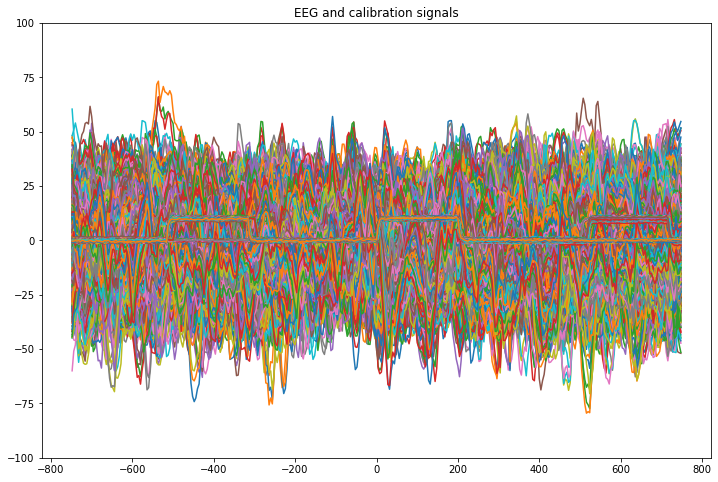

In [11]:
f_eeg, ax = plt.subplots(figsize=(12, 8))
ax.set_title("EEG and calibration signals")
ax.set_ylim(-100, 100)
times = p3_df.time_ms.unique()
for epoch_id, epoch in p3_df.groupby("epoch_id"):
    ax.plot(times, epoch[EEG_COLUMNS])

## Compute time-domain average ERPs

In [12]:
p3_erp = p3_df.groupby(["stimulus", "time_ms"]).mean()[EEG_COLUMNS]
p3_std = p3_df.groupby(["stimulus", "time_ms"]).std()[EEG_COLUMNS]
p3_n = p3_df.groupby(["stimulus", "time_ms"]).count()[EEG_COLUMNS]  # n's differs by condition after data QC

for df in [p3_erp, p3_std, p3_n]:
    df.columns.name = "channel"

## Example Figure: P300 midline ERP plots with Psychological Science matlab style sheets


https://www.psychologicalscience.org/publications/aps-figure-format-style-guidelines

2020-08-11

(emphasis in bold added here)


Details:


Please note that yellow may not show up well, especially in line graphs.

In __all labels including the key( the first letter of each important word and of any word of at least 4 letters should be capitalized__.

Exception: Units of measure indicated in parentheses don't have the first letter capitalized, e.g., "Response Time (ms)."

Minus signs **NOT HYPHENS** should be used to indicate negative numbers or subtraction (a minus sign can be inserted by holding down the <Alt> key on a computer keyboard while pressing 0, 1, 5, 0 on the number pad, in sequence).

__Do not insert a box around a key or a figure.)__

A graph should have two axes (ordinate and abscissa) only. Do not include extraneous axes.
In mathematical expressions, there should be a single letter space before and after each operator: =, ×, +, ?, <, >, etc.

Exception: Do not insert spaces in subscripts or superscripts.

The __ordinate axis must be labeled to indicate the nature of the quantities referred to__. For example, if a graph shows response times (ordinate) in various conditions (abscissa), the ordinate must be labeled "Response Time," in addition to showing the numerical values.

Numerical values on the ordinate axis should be oriented horizontally.
If a figure includes error bars, they must be explained in the caption. In the case of a bar graph, be sure that error bars are easily visible (e.g., a black error bar will be invisible in a data bar with a black or dark-gray fill).

Font style and size:

Labels and numbers in figures should be in __Helvetica Neue 57 Condensed roman font__. (If you do not have this font installed on your device, please use regular __Helvetica__ or Arial font.)

Do not use boldface font unless it's intended to highlight something. In that case, the caption should explain what the boldface indicates.

Symbols referring to variables should be in Helvetica Neue 57 Condensed italic font. (If you do not have this font installed on your device, please use regular Helvetica or Arial font.) Otherwise, do not use italics.

Greek letters (e.g., regression coefficients) should not be in italics.

All __ordinate and abscissa__ quantities, or any sublabel along the ordinate or abscissa, should be in __9-point__ font.

All __main ordinate and abscissa labels__ should be in __10-point__ font.

The __title__ header (at the top of a figure), if there is one, should be in __12-point__ font.

__Keys__ should be in __9-point__ font.

This includes the height of boxes illustrating fills in a bar graph and symbols used to differentiate lines in a line graph.

Whenever possible, the __key should be placed toward the top of a graph__ (i.e., toward the top inside the graph or above the graph, as space allows).

Symbols (e.g., squares, diamonds) plotted in a graph should be no smaller than the corresponding symbols in the key.

__Panel labels (a, b, c, etc.) should be in 18-point font, lowercase, positioned to the upper left of the corresponding 
panels__. They should not be followed by periods or surrounded by parentheses.

__All other__ text in graphs (e.g., a label for a graphed line or symbol) should be in __9-point__ font.




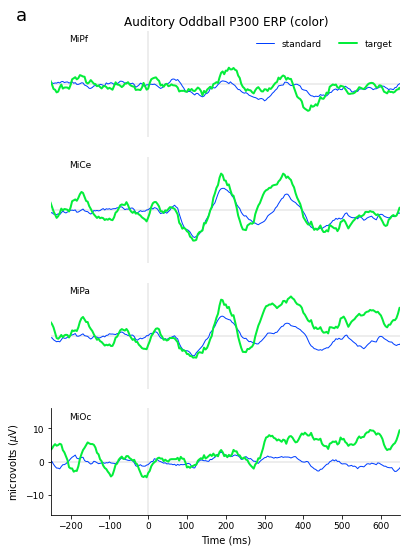

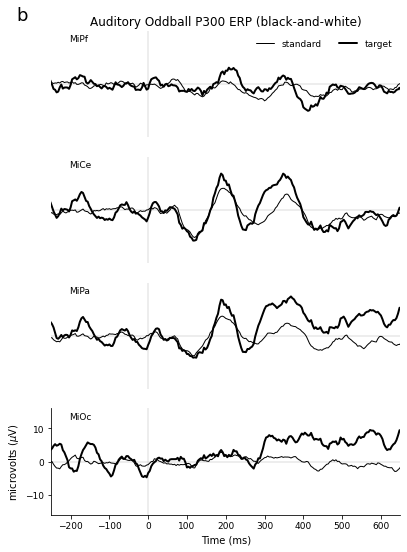

In [13]:
# seaborn bright
colors = ['#003FFF', '#03ED3A', '#E8000B', '#8A2BE2'] # , '#FFC400', '#00D7FF']

n_colors = len(colors)

psych_sci_fig = {
    # set matplotlib style paramaters to Psych Science specs
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 18,   # default size for panel label
    "axes.labelsize": 10, # X, Y axis labels
    "axes.titlesize": 12,  # axes title
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.frameon": False,
    "lines.linewidth": 2,
    "lines.markersize": 8,
    
    # set other aesthetics to taste
    "lines.color": "lightgray",
    "lines.solid_capstyle": "round",
    "lines.dash_capstyle": "round",
    "lines.dashdot_pattern": [6.4, 1.6, 1.0, 1.6],
    "lines.dashed_pattern": [4.0, 5.0],
    "lines.dotted_pattern": [0.01, 2.5],
    
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.prop_cycle": (
        cycler(lw=["1", "2", "3", "3.5"])
        + cycler(ls=["-", "-", "-", "--"])
    )
}

# this cycles colors from our colorbrewer palette
cco = (cycler(color=colors))

# this "cycles" all black lines
cbw = cycler(color=["k"] * len(colors))


# Figures work in color or black-and-white
panels = {
    "a": {"subtitle": "color", "lines": cco}, 
    "b": {"subtitle": "black-and-white", "lines": cbw}
}


n_chan = len(EEG_MIDLINE)

 
for fig_n, (panel, design) in enumerate(panels.items()):
    with plt.style.context(psych_sci_fig):

        # update panel style with line colors
        plt.rcParams["axes.prop_cycle"] = (
            plt.rcParams["axes.prop_cycle"]
            + design["lines"]
        )

        # new figure
        f_ep, axs = plt.subplots(n_chan, 1, figsize=(6, 2 * n_chan), sharex=True, sharey=True)

        for axi, chan in enumerate(EEG_MIDLINE):

            ax = axs[axi]
            
            # zero-lines
            ax.axvline(0, alpha=0.4)
            ax.axhline(0, alpha=0.4)
            ax.text(0.05, 0.9, s=chan, transform=ax.transAxes, fontsize=9) 

            # ERP waveforms, line styles from the style sheet
            for stim, erp in p3_erp.query("stimulus != 'cal'").groupby(["stimulus"]):
                erp = erp.reset_index()
                time = erp.time_ms.unique()
                ax.plot(time, erp[chan], label=stim)
   
            # panel label and title
            if axi == 0:
                ax.text(-0.1, 1.1, s=f"{panel}", transform=ax.transAxes)
                ax.set_title(f"Auditory Oddball P300 ERP ({design['subtitle']})")
                ax.legend(loc="upper right", ncol=2)

            ax.set(xlim=(-250, 650))
            ax.set(ylim=(-16, 16))

            # style the axes
            if axi == n_chan - 1:

                ax.set_xlabel("Time (ms)")
                ax.spines["left"].set_visible(True)
                ax.spines["bottom"].set_visible(True)

                ax.set_ylabel(r"microvolts ($\mu\mathrm{V}$)")
            else:
                ax.tick_params(bottom=False, labelbottom=False)
                ax.tick_params(left=False, labelleft=False)

  
        f_ep.tight_layout()
        f_ep.savefig(f"generated/p3_midline_plot{fig_n+1}.pdf")
        


# Plot ERP scalp distribution and decorations

* box highlight an interval with a`x.axvspan(from, to, ...)`

* add uncertainty intervals around y +/- u with `ax.fill_between(x, y1=y + u, y2=y-u, ...)`

* highlight a cond1 vs. cond2 effect in an interval with `ax.fill_between(x, y1=cond1, y2=cond2, where, ...)`
 

In [14]:
# more styling for bare axes ...
head_trace_style = {
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.left": False,
    "ytick.labelleft": False,
    "axes.prop_cycle": cco,
    "font.size": 9,
}


# semi-topographic locations
MPL_32_HEAD = {
    'w': .15,
    'h': .1,
    'chanlocs': {
        'cal': (0.0625, 0.2),  
        'lle': (0.25, 0.85),
        'rle': (0.625, 0.85),
        'lhz': (0.0625, 0.85),
        'rhz': (0.8125, 0.85),
        'MiPf': (0.4375, 0.725),
        'MiCe': (0.4375, 0.425),
        'MiPa': (0.4375, 0.275),
        'MiOc': (0.4375, 0.125),
        'LLPf': (0.1875, 0.725),
        'RLPf': (0.6875, 0.725),
        'LMPf': (0.3125, 0.65),
        'RMPf': (0.5625, 0.65),
        'LLFr': (0.0625, 0.5),
        'RLFr': (0.8125, 0.5),
        'LMFr': (0.3125, 0.5),
        'RMFr': (0.5625, 0.5),
        'LDFr': (0.1875, 0.575),
        'RDFr': (0.6875, 0.575),
        'LDCe': (0.1875, 0.425),
        'RDCe': (0.6875, 0.425),
        'LLTe': (0.0625, 0.35),
        'RLTe': (0.8125, 0.35),
        'LMCe': (0.3125, 0.35),
        'RMCe': (0.5625, 0.35),
        'LMOc': (0.3125, 0.2),
        'RMOc': (0.5625, 0.2),
        'LDPa': (0.1875, 0.275),
        'RDPa': (0.6875, 0.275),
        'LLOc': (0.1875, 0.125),
        'RLOc': (0.6875, 0.125),
        'A2': (0.8125, 0.2)
    }
}

MPL_MIDLINE = {
    'w': .75,
    'h': .2,
    'chanlocs': {
        'MiPf': (0.1, 0.7),
        'MiCe': (0.1, 0.5),
        'MiPa': (0.1, 0.3),
        'MiOc': (0.1, 0.1),
        'cal': (0.1, 0.1),
    }
}


## Define the decorations

In [15]:
# timeline, ticks, and labels
tmin, tmax = -200, 600
timeline_ticks = [-200, 0, 200, 400, 600]
timeline_ticklabels = [-200, 0, 200, 400, "600 ms"]


# cal bar in x, y data units
cal_bar_time = 0  # ms
cal_bar_min = 0  # uV
cal_bar_max = 5  # uV
cal_tick_width = 25  # ms

# cal bar line aesthetics
cal_bar_kws = {"color": "black", "lw": 1} 

# cal bar label kwargs
cal_bar_label = {
    "x": cal_bar_time + cal_tick_width,
    "y": cal_bar_max / 2.0 , 
    "s": f"{cal_bar_max}" + r"$\mu\mathrm{V}$",
    "ha": "left",
    "va": "center",
}

# channel label kwargs, label text is per channel
chan_label = {
    "x": cal_bar_time,
    "y": cal_bar_max , 
    "ha": "center",
    "va": "bottom",
}

# -------------------------------
# montage and figure proportions

# chans = EEG_MIDLINE + ["cal"]
# chan_layout = MPL_MIDLINE

chans = EEG_COLUMNS + ["cal"]
chan_layout = MPL_32_HEAD
figsize = (16, 14)

# conditions to plot, add "cal" for fun
plot_stim = ["standard", "target"]

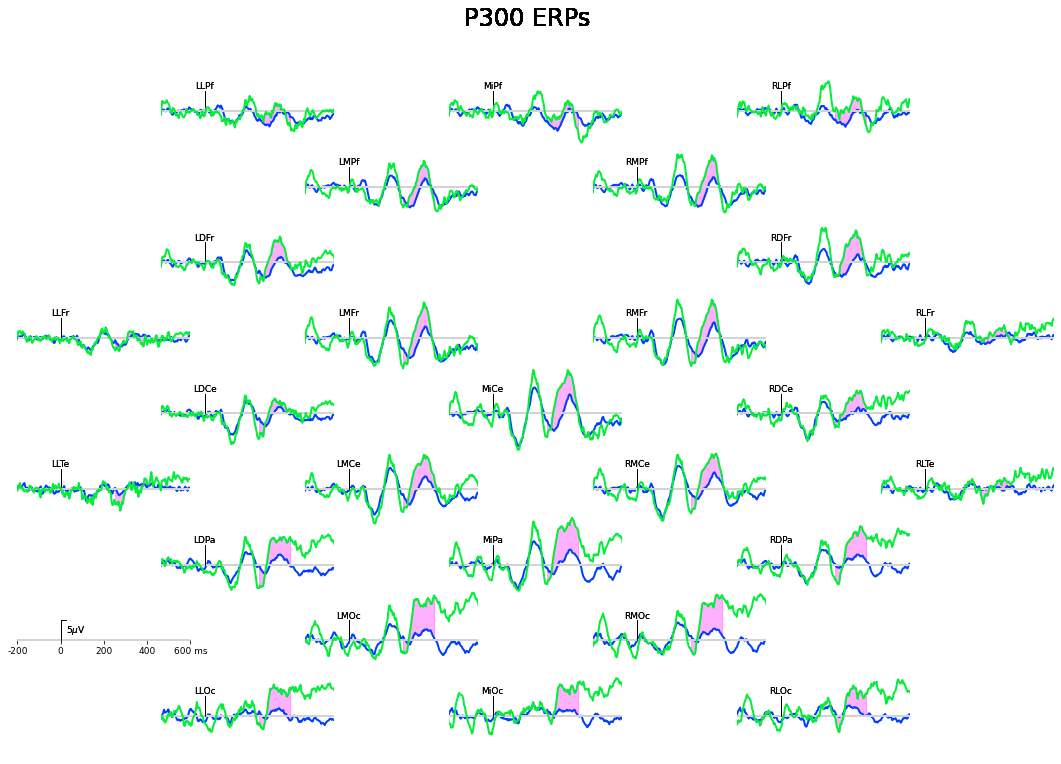

In [16]:
# plot it
with plt.style.context([psych_sci_fig, head_trace_style]):
    
    fig, axs = plt.subplots(len(chans), figsize=figsize, sharey=True, sharex=True)
    
    # proportions 
    chan_width = chan_layout["w"]   # .2
    chan_height = chan_layout["h"]  # .1
    
    for axi, chan in enumerate(chans):
        
        # axis
        ax = axs[axi]
        ax.patch.set_alpha(0.0)  # see through
        ax.set_xlim(tmin, tmax)
            
        
        # lower left corner for this channel
        x0, y0 = chan_layout["chanlocs"][chan]
  
        # locate this channel
        bbox = mpl.transforms.Bbox([[x0, y0], [x0 + chan_width, y0 + chan_height]])
        ax.set_position(bbox)
        
        # ERP waveforms, line styles from the style sheet
        for stim, erp in p3_erp.query("stimulus in @plot_stim").groupby(["stimulus"]):
            
            # all axes get timeline, vertical cal bar
            ax.axhline(0, color='lightgray')
            ax.plot(
                [0, 0], 
                [cal_bar_min, cal_bar_max], 
                **cal_bar_kws
            )
            
            # --------------------------------------
            # special handling for cal and timeline
            if chan == "cal":
                ax.spines["bottom"].set_position(("data", 0))
                ax.set_xticks(timeline_ticks)
                ax.set_xticklabels(timeline_ticklabels)
                ax.tick_params(bottom=True, labelbottom=True)
                ax.plot(
                    [cal_bar_time, cal_tick_width], 
                    [cal_bar_max, cal_bar_max], 
                    **cal_bar_kws
                )
                ax.text(**cal_bar_label)
                continue
            
            # --------------------------
            # ERP label and traces
            ax.text(s=chan, **chan_label)
            erp = erp.reset_index()
            time = erp.time_ms.unique()
            ax.plot(time, erp[chan], label=stim)
   
            # Example: highlight P300 effect
            if stim == 'target':
                # pick one condition, fill to the other
                y2 = p3_erp.query("stimulus=='standard'")[chan]
                when = (time >= 250) & (time < 400) # highlight interval
                ax.fill_between(
                    time, 
                    y1=erp[chan], 
                    y2=y2, 
                    where=when, 
                    color="magenta", 
                    alpha=.3
                )
        # set the title on the way out, ax doesn't matter, position is in fig coords.
        ax.text(x=.45, y=.85, s="P300 ERPs", size=24, transform=fig.transFigure)
        

# Compute mean P300 ERP

In [17]:
# compute mean amplitude 250 - 450 ms, standards, targets, and difference=target - standard
p300_amp = (
    p3_erp.query(
        "stimulus != 'cal' and time_ms >= 250 and time_ms < 450"
    ).groupby("stimulus")[EEG_COLUMNS]
    .mean()#
    .T
    .unstack()
    .to_frame()
)
p300_amp.columns = ["amplitude"]

# compute the P300 effect: target - standard
p300_amp_diff = p300_amp.unstack(0).apply(lambda row : row[1] - row[0], axis=1).to_frame()
p300_amp_diff.columns = ["amplitude"]
p300_amp_diff["stimulus"] = "difference"
p300_amp_diff = p300_amp_diff.reset_index().set_index(["stimulus", "channel"])

p300_amp = pd.concat([p300_amp, p300_amp_diff])
p300_amp

amplitude
stimulus   channel           
standard   MiPf     -2.322935
           LLPf     -1.924552
           LLFr     -0.239627
           LLTe      0.564894
           LLOc      0.213780
...                       ...
difference LMCe      3.214108
           MiPa      5.914676
           RMCe      2.656957
           RMFr      1.931009
           MiCe      3.280381

[78 rows x 1 columns]

## Merge P300 mean amplitude with electrode locations

In [18]:
p300_amp_locs = (
    p300_amp.reset_index("stimulus")
    .merge(
        SPH_CART_LOCS[["channel", "x_lambert", "y_lambert"]], 
        on="channel"
    )
)
p300_amp_locs

,channel,stimulus,amplitude,x_lambert,y_lambert
0,MiPf,standard,-2.322935,6.123234e-17,1.000000
1,MiPf,target,-2.309737,6.123234e-17,1.000000
2,MiPf,difference,0.013199,6.123234e-17,1.000000
3,LLPf,standard,-1.924552,-5.877853e-01,0.809017
4,LLPf,target,-1.445431,-5.877853e-01,0.809017
...,...,...,...,...,...
73,RMFr,target,0.246611,1.869914e-01,0.257372
74,RMFr,difference,1.931009,1.869914e-01,0.257372
75,MiCe,standard,-1.254791,0.000000e+00,0.000000
76,MiCe,target,2.025590,0.000000e+00,0.000000


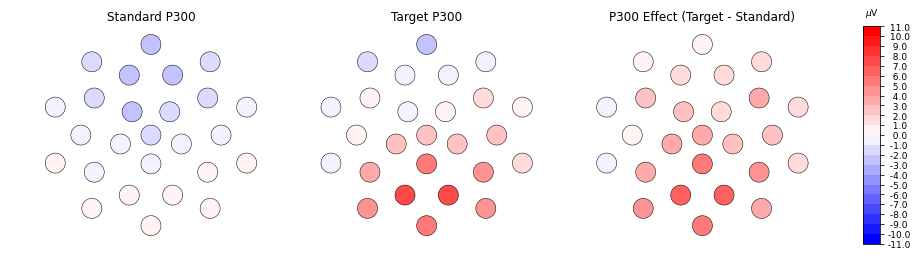

In [19]:

head_plot_style = {
    "axes.xmargin": 0.1,
    "axes.ymargin": 0.1,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "xtick.color": "none",
    "ytick.color": "none",
    "lines.markersize": 20
    
}


# set up the color mapping
lower, upper = -11, 11
n_shades = 10  # for each color

n_colors = (2 * n_shades) + 2
bounds = np.linspace(lower, upper, n_colors + 1)
bwr_norm = mpl.colors.BoundaryNorm(bounds, n_colors)

# get blue-white-red divergent colormap
bwr_cmap = mpl.cm.get_cmap('bwr', n_colors)




with plt.style.context([psych_sci_fig, head_plot_style]):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4),)
    
 
    stimulus = ["standard", "target", "difference"]
    for axi, stim in enumerate(stimulus):
        data = p300_amp_locs.query("stimulus == @stim")
        ax = axs[axi]
        if stim == "difference":
            ax.set_title("P300 Effect (Target - Standard)")
        else:
            ax.set_title(f"{stim.capitalize()} P300")
        p = ax.scatter(
            data["x_lambert"], 
            data["y_lambert"], 
            c=data["amplitude"],
            marker="o",
            cmap = bwr_cmap,
            norm=bwr_norm,
            lw=.5,
            edgecolor='k'
        )
        ax.set_aspect(0.9)
    
    axins = axs[-1].inset_axes([1.2, 0, .075, 1])
    cb = fig.colorbar(
        p, 
        cax=axins,
        ticks=bounds,
    )
    cb.ax.tick_params(axis="y", color='k')
    cb.ax.set_yticklabels(bounds, color='k')
    #cb.ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:5.1f}"))
    cb.ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:5.1f}"))
    cb.ax.text(
        x=0.5, 
        y=1.05, 
        s=r"$\mu\mathrm{V}$",
        fontsize=9, 
        transform=cb.ax.transAxes, 
        ha="center"
    )
    fig.savefig("generated/p3_head_plot3.pdf", format="pdf", bbox_inches="tight")